# Cutting Stock Problem – Standard ILP Formulation

We consider large rolls of length $L$, and a demand for smaller rolls of various lengths. Cutting a large roll into smaller ones according to a feasible combination defines a *pattern*.

---

### Parameters

- $N$: index set of available rolls
- $L$: length of each large roll
- $b_i$: demand for item $i$
- $l_i$: length of item $i$

---

### Decision Variables

- $y_n$: equals $1$ if roll $n$ is used (cut), and $0$ otherwise
- $x_i^n$: number of times item $i$ is cut from roll $n$

---

### Integer Linear Program

Objective:

$$
\min \sum_{n \in N} y_n
$$

Demand satisfaction:

$$
\sum_{n \in N} x_i^n \ge b_i \quad \text{for } i = 1, 2, \dots, m
$$

Capacity constraint on each roll:

$$
\sum_{i=1}^m l_i x_i^n \le L y_n \quad \text{for all } n \in N
$$

Integrality:

$$
x_i^n \ge 0 \text{ integer}
$$

$$
y_n \in \{0, 1\} \quad \text{for all } n \in N
$$


## Example Pattern

We consider a large roll of length $L = 70$.

A feasible cutting pattern is:

- $3$ rolls of length $l_1 = 17$
- $1$ roll of length $l_2 = 15$
- waste = $4$

Total used length:

$$
3 \times 17 + 1 \times 15 = 66
$$

Remaining unused material:

$$
70 - 66 = 4
$$

This combination forms a valid cutting pattern because the sum of allocated item lengths does not exceed $L$.

The idea is that each pattern specifies how one large roll is cut. Later, in the full cutting stock model, patterns become the columns in the master LP, and the goal is to select the minimum number of rolls (patterns) such that all demands are satisfied.


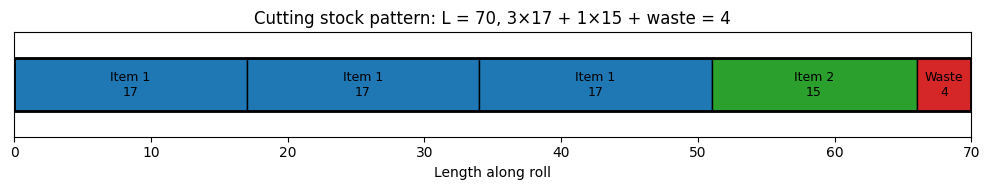

In [3]:
# %% [markdown]
# # Cutting stock example: visualizing one pattern
# Large roll of length L = 70
# Pattern: 3 items of length l1 = 17, 1 item of length l2 = 15, and waste = 4.

# %%
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Parameters
L = 70
segments = [
    ("Item 1", 17, 3),  # (label, length, count)
    ("Item 2", 15, 1),
    ("Waste", 4, 1),
]

# Build list of actual pieces along the roll (flattened with repetition)
pieces = []
for label, length, count in segments:
    for _ in range(count):
        pieces.append((label, length))

# Colors per type (you can adjust)
color_map = {
    "Item 1": "tab:blue",
    "Item 2": "tab:green",
    "Waste": "tab:red",
}

fig, ax = plt.subplots(figsize=(10, 2))

current_x = 0
y_bottom = 0.25
height = 0.5

for label, length in pieces:
    rect = Rectangle((current_x, y_bottom), length, height,
                     edgecolor="black",
                     facecolor=color_map.get(label, "lightgray"))
    ax.add_patch(rect)
    
    # Center label in the segment
    ax.text(current_x + length / 2,
            y_bottom + height / 2,
            f"{label}\n{length}",
            ha="center",
            va="center",
            fontsize=9)
    
    current_x += length

# Main roll outline (optional, but nice)
outer = Rectangle((0, y_bottom), L, height,
                  edgecolor="black",
                  facecolor="none",
                  linewidth=2)
ax.add_patch(outer)

# Aesthetics
ax.set_xlim(0, L)
ax.set_ylim(0, 1)
ax.set_xlabel("Length along roll")
ax.set_yticks([])
ax.set_title("Cutting stock pattern: L = 70, 3×17 + 1×15 + waste = 4")

plt.tight_layout()
plt.show()


In [5]:
# %% [markdown]
# # Cutting Stock – ILP with PuLP (Standard Formulation)
# 
# We model the cutting stock problem using the ILP formulation:
# 
# - Large roll length: L = 70
# - Item types:
#     - Item 1: length l1 = 17
#     - Item 2: length l2 = 15
# - Decision variables:
#     - y_n = 1 if roll n is used, 0 otherwise
#     - x_i^n = number of times item i is cut on roll n
# - Objective: minimize total number of rolls used
#
# In this notebook, we:
# 1. Define data (L, item lengths, demands).
# 2. Build the ILP model with PuLP.
# 3. Solve it.
# 4. Inspect the solution patterns roll by roll.

# %%


In [3]:
import pulp as pl

In [12]:
# %% [markdown]
# ## 1. Problem data

# %%
# Length of the large roll
L = 70

# Item lengths (i -> l_i)
item_lengths = {
    1: 17,  # item 1
    2: 15,  # item 2
    3: 20   # need at least 6 pieces of length 15

}

# Demands (i -> b_i)
# You can change these numbers to try different instances
demands = {
    1: 8,   # need at least 8 pieces of length 17
    2: 6,   # need at least 6 pieces of length 15
    3: 7   # need at least 6 pieces of length 15

}

items = list(item_lengths.keys())

# Upper bound on number of rolls (N)
# In the worst case you might use one roll per item.
N_max = sum(demands.values())
rolls = list(range(N_max))

print("Items:", items)
print("Roll indices (N):", rolls)
print("L =", L)
print("item_lengths =", item_lengths)
print("demands =", demands)


Items: [1, 2, 3]
Roll indices (N): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
L = 70
item_lengths = {1: 17, 2: 15, 3: 20}
demands = {1: 8, 2: 6, 3: 7}


In [13]:
# %% [markdown]
# ## 2. Build the ILP model in PuLP
# 
# We create:
# - Binary variables y_n for each roll n in N
# - Integer variables x_i^n for each item i and roll n
# 
# The model:
# 
# - Objective:
#   minimize sum_n y_n
# 
# - Demand constraints:
#   for each i: sum_n x_i^n >= b_i
# 
# - Capacity constraints:
#   for each n: sum_i l_i * x_i^n <= L * y_n

# %%
# Create the problem
problem = pl.LpProblem("CuttingStock_ILP", pl.LpMinimize)

# Decision variables
y = pl.LpVariable.dicts(
    "y", rolls, lowBound=0, upBound=1, cat=pl.LpBinary
)

x = pl.LpVariable.dicts(
    "x",
    (items, rolls),  # x[i][n]
    lowBound=0,
    cat=pl.LpInteger,
)

# Objective: minimize number of rolls used
problem += pl.lpSum(y[n] for n in rolls), "Minimize_number_of_rolls"

# Demand constraints: sum_n x_i^n >= b_i
for i in items:
    problem += (
        pl.lpSum(x[i][n] for n in rolls) >= demands[i],
        f"Demand_item_{i}",
    )

# Capacity constraints: sum_i l_i x_i^n <= L y_n for each roll n
for n in rolls:
    problem += (
        pl.lpSum(item_lengths[i] * x[i][n] for i in items) <= L * y[n],
        f"Capacity_roll_{n}",
    )

print(problem)


CuttingStock_ILP:
MINIMIZE
1*y_0 + 1*y_1 + 1*y_10 + 1*y_11 + 1*y_12 + 1*y_13 + 1*y_14 + 1*y_15 + 1*y_16 + 1*y_17 + 1*y_18 + 1*y_19 + 1*y_2 + 1*y_20 + 1*y_3 + 1*y_4 + 1*y_5 + 1*y_6 + 1*y_7 + 1*y_8 + 1*y_9 + 0.0
SUBJECT TO
Demand_item_1: x_1_0 + x_1_1 + x_1_10 + x_1_11 + x_1_12 + x_1_13 + x_1_14
 + x_1_15 + x_1_16 + x_1_17 + x_1_18 + x_1_19 + x_1_2 + x_1_20 + x_1_3 + x_1_4
 + x_1_5 + x_1_6 + x_1_7 + x_1_8 + x_1_9 >= 8

Demand_item_2: x_2_0 + x_2_1 + x_2_10 + x_2_11 + x_2_12 + x_2_13 + x_2_14
 + x_2_15 + x_2_16 + x_2_17 + x_2_18 + x_2_19 + x_2_2 + x_2_20 + x_2_3 + x_2_4
 + x_2_5 + x_2_6 + x_2_7 + x_2_8 + x_2_9 >= 6

Demand_item_3: x_3_0 + x_3_1 + x_3_10 + x_3_11 + x_3_12 + x_3_13 + x_3_14
 + x_3_15 + x_3_16 + x_3_17 + x_3_18 + x_3_19 + x_3_2 + x_3_20 + x_3_3 + x_3_4
 + x_3_5 + x_3_6 + x_3_7 + x_3_8 + x_3_9 >= 7

Capacity_roll_0: 17 x_1_0 + 15 x_2_0 + 20 x_3_0 - 70 y_0 <= 0

Capacity_roll_1: 17 x_1_1 + 15 x_2_1 + 20 x_3_1 - 70 y_1 <= 0

Capacity_roll_2: 17 x_1_2 + 15 x_2_2 + 20 x_3_2 - 70 

In [14]:
# %% [markdown]
# ## 3. Solve the model

# %%
# Choose a solver (default CBC ships with PuLP)
solution_status = problem.solve(pl.PULP_CBC_CMD(msg=True))

print("Status:", pl.LpStatus[solution_status])
print("Optimal objective (number of rolls):", pl.value(problem.objective))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/musel/Documents/github/cutting-stock/.venv/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/71acc7f6e36742fdadf5da8f3b9aefd7-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/71acc7f6e36742fdadf5da8f3b9aefd7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 29 COLUMNS
At line 366 RHS
At line 391 BOUNDS
At line 476 ENDATA
Problem MODEL has 24 rows, 84 columns and 147 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5.22857 - 0.00 seconds
Cgl0004I processed model has 24 rows, 84 columns (84 integer (21 of which binary)) and 147 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 7 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0012I Integer solution of 6 found by DiveCoefficient afte

In [15]:
# %% [markdown]
# ## 4. Inspect solution: which rolls are used and how they are cut
# 
# For each roll n with y_n = 1, we print:
# - the counts x_i^n for each item
# - the total used length and the waste

# %%
used_rolls = []

for n in rolls:
    if pl.value(y[n]) > 0.5:  # roll is used
        pattern = {}
        used_length = 0
        for i in items:
            qty = int(round(pl.value(x[i][n])))
            if qty > 0:
                pattern[i] = qty
                used_length += qty * item_lengths[i]
        
        waste = L - used_length
        used_rolls.append((n, pattern, used_length, waste))

# Pretty print
for (n, pattern, used_length, waste) in used_rolls:
    print(f"Roll {n}:")
    for i, qty in pattern.items():
        print(f"  Item {i} (length {item_lengths[i]}): {qty} pieces")
    print(f"  Used length = {used_length}, waste = {waste}")
    print("-" * 40)


Roll 2:
  Item 1 (length 17): 1 pieces
  Item 3 (length 20): 2 pieces
  Used length = 57, waste = 13
----------------------------------------
Roll 5:
  Item 1 (length 17): 2 pieces
  Item 3 (length 20): 1 pieces
  Used length = 54, waste = 16
----------------------------------------
Roll 10:
  Item 1 (length 17): 1 pieces
  Item 2 (length 15): 2 pieces
  Used length = 47, waste = 23
----------------------------------------
Roll 12:
  Item 1 (length 17): 4 pieces
  Used length = 68, waste = 2
----------------------------------------
Roll 15:
  Item 2 (length 15): 2 pieces
  Item 3 (length 20): 2 pieces
  Used length = 70, waste = 0
----------------------------------------
Roll 16:
  Item 2 (length 15): 2 pieces
  Item 3 (length 20): 2 pieces
  Used length = 70, waste = 0
----------------------------------------
